# AffectNet Datasets

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

In [66]:
from pathlib import Path

import numpy as np
import pandas as pd

import pytorch_lightning as pl

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

%matplotlib inline

from src.data.affectnet_datamodule import AffectNetAUDataModule, AffectNetImageDataModule

In [3]:
pl.seed_everything(42)

Global seed set to 42


42

In [4]:
label_type = ['arousal', 'valence', 'expression']
data_basepth = Path('../data/')
val_split = 0.1
batch_size = 100

## Facial Action Unit Dataset Review

In [5]:
dm = AffectNetAUDataModule(label_type, data_basepth, val_split, batch_size)
dm.prepare_data()
dm.setup(stage=None)

In [6]:
train_ds = dm.train_dataset.dataset[dm.train_dataset.indices]
val_ds = dm.val_dataset.dataset[dm.val_dataset.indices]
test_ds = dm.test_dataset[np.arange(len(dm.test_dataset))]

In [7]:
df_fau_train = pd.DataFrame(data=train_ds[0], columns=dm.feature_names)
df_fau_train[label_type] = train_ds[1]
df_fau_train['img_id'] = train_ds[2]
df_fau_train = df_fau_train.astype({"expression": int}, errors='raise') 

df_fau_val = pd.DataFrame(data=val_ds[0], columns=dm.feature_names)
df_fau_val[label_type] = val_ds[1]
df_fau_val['img_id'] = val_ds[2]
df_fau_val = df_fau_val.astype({"expression": int}, errors='raise') 

df_fau_test = pd.DataFrame(data=test_ds[0], columns=dm.feature_names)
df_fau_test[label_type] = test_ds[1]
df_fau_test['img_id'] = test_ds[2]
df_fau_test = df_fau_test.astype({"expression": int}, errors='raise') 

df_fau_train['partition'] = 'train'
df_fau_val['partition'] = 'val'
df_fau_test['partition'] = 'test'

df_fau_full = pd.concat([df_fau_train, df_fau_val, df_fau_test], axis=0)

In [15]:
df_fau_full[['arousal', 'valence', 'expression', 'partition']].groupby(['partition']).describe()

arousal                                                    \
              count      mean       std       min       25%       50%   
partition                                                               
test         3851.0  0.352137  0.379199 -0.666667  0.015873  0.439959   
train      250497.0  0.117758  0.301274 -0.971666 -0.055556  0.068902   
val         27833.0  0.119025  0.300590 -0.785714 -0.055556  0.069013   

                                valence            ...                      \
                75%       max     count      mean  ...       75%       max   
partition                                          ...                       
test       0.664251  0.984127    3851.0 -0.192631  ...  0.033875  0.982385   
train      0.227449  0.996903  250497.0  0.189625  ...  0.655625  0.999081   
val        0.228634  0.992064   27833.0  0.191506  ...  0.655625  0.987598   

          expression                                               
               count      mean       std  min  25%  50%  75%  max  
partition                                                          
test          3851.0  3.506362  2.294691  0.0  2.0  3.0  6.0  7.0  
train       250497.0  1.554019  1.809499  0.0  0.0  1.0  2.0  7.0  
val          27833.0  1.546402  1.797989  0.0  0.0  1.0  2.0  7.0  

[3 rows x 24 columns]

### Histograms of Dimensional Labels Per Emotion Category

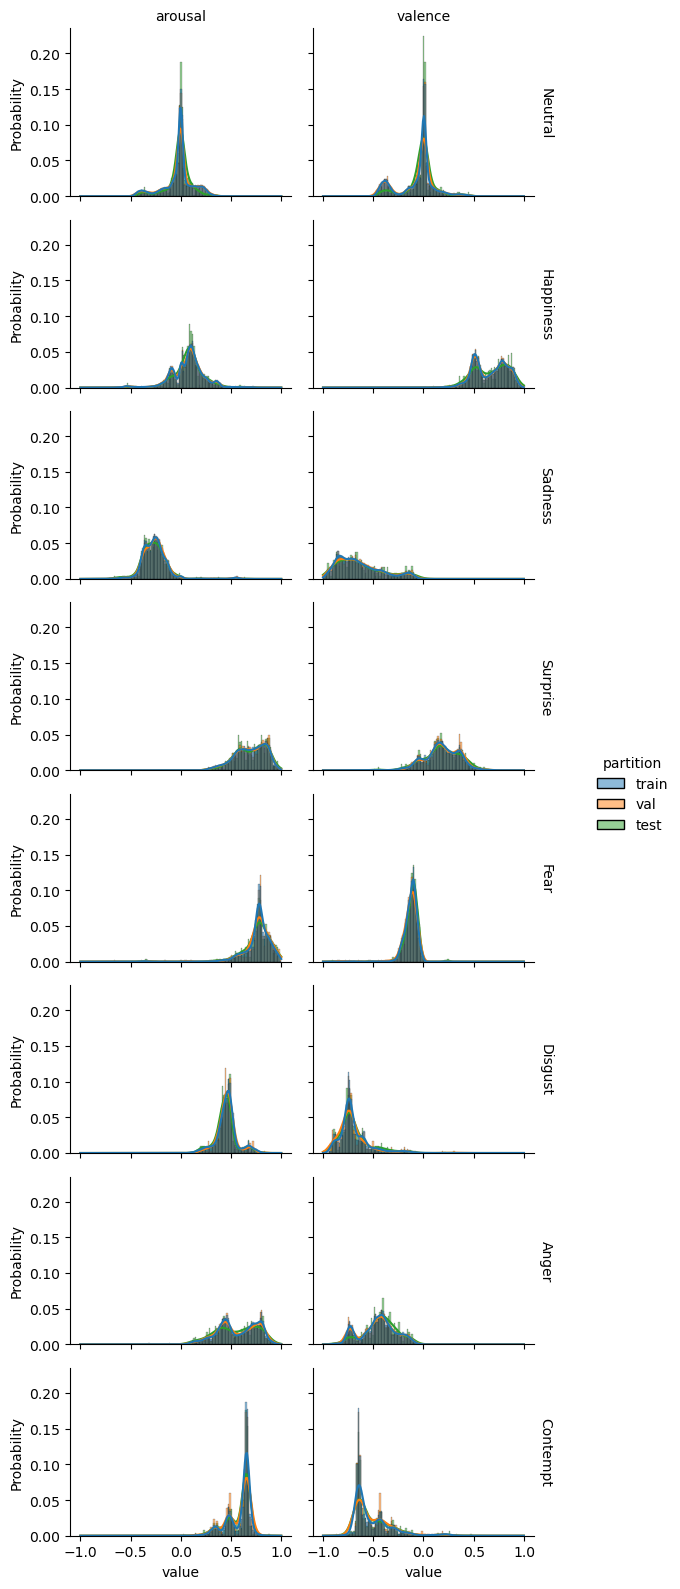

In [9]:
df_histplot_melt = df_fau_full[['arousal', 'valence', 'partition', 'expression', 'img_id']].melt(id_vars=['partition', 'img_id', 'expression'])
label_map = {i: name for i, name in enumerate(dm.expression_labels)}
df_histplot_melt['expression'] = df_histplot_melt['expression'].map(label_map)
g = sns.displot(
    df_histplot_melt, x="value", row='expression', col="variable", hue="partition",
    kind='hist', stat='probability', common_norm=False, kde=True,
    aspect=1.5, height=2, row_order=dm.expression_labels, 
    facet_kws = {'margin_titles': True}
)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}');

### Facial Action Unit Distributions Per Emotion Category

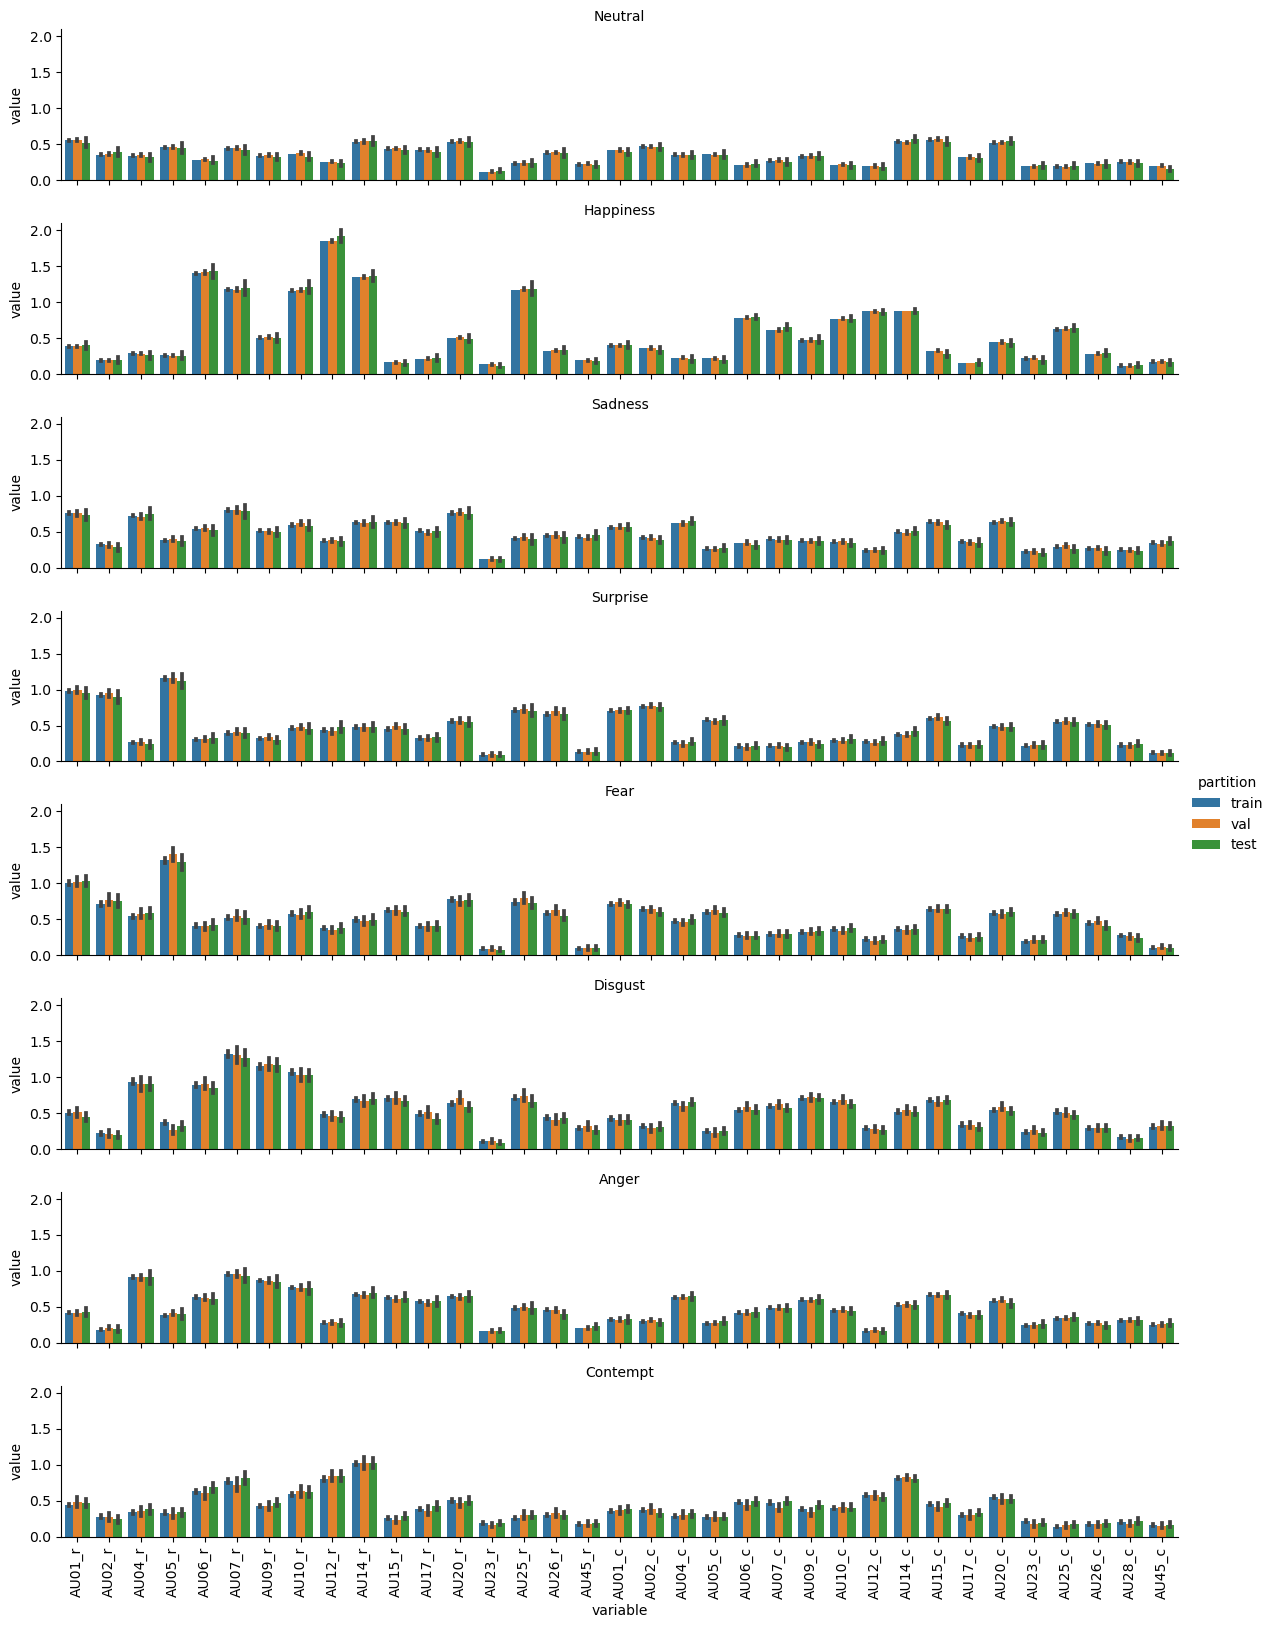

In [10]:
df_catplot_melt = df_fau_full.drop(['arousal', 'valence'], axis=1).melt(id_vars=['partition', 'img_id', 'expression'])
label_map = {i: name for i, name in enumerate(dm.expression_labels)}
df_catplot_melt['expression'] = df_catplot_melt['expression'].map(label_map)
g = sns.catplot(
    data=df_catplot_melt, x='variable', y='value', hue='partition', row='expression', kind='bar', 
    aspect=6, height=2, row_order=dm.expression_labels, 
    facet_kws = {'margin_titles': True}
)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.set_xticklabels(rotation=90);

## Image Dataset Review

In [11]:
label_type = ['arousal', 'valence', 'expression']
data_root = Path('../data/')
val_split = 0.2
batch_size = 100

In [12]:
dm = AffectNetImageDataModule(label_type=label_type, data_root=data_root, val_split=val_split, batch_size=batch_size, refresh_cache=False, keep_as_pandas=True)
dm.prepare_data()
dm.setup(stage=None)

In [51]:
df_img_train = dm.train_dataset.dataset.df.iloc[dm.train_dataset.indices]
df_img_train = df_img_train.reset_index()
df_img_train = df_img_train.astype({"expression": int}, errors='raise') 
df_tmp = pd.DataFrame(data=['train']*len(df_img_train), columns=['partition'])
df_img_train = pd.concat([df_img_train, df_tmp], axis=1)

df_img_val = dm.val_dataset.dataset.df.iloc[dm.val_dataset.indices]
df_img_val = df_img_val.reset_index()
df_img_val = df_img_val.astype({"expression": int}, errors='raise') 
df_tmp = pd.DataFrame(data=['val']*len(df_img_val), columns=['partition'])
df_img_val = pd.concat([df_img_val, df_tmp], axis=1)

df_img_test = dm.test_dataset.df
df_img_test = df_img_test.reset_index()
df_img_test = df_img_test.astype({"expression": int}, errors='raise') 
df_tmp = pd.DataFrame(data=['test']*len(df_img_test), columns=['partition'])
df_img_test = pd.concat([df_img_test, df_tmp], axis=1)

df_img_all = pd.concat([df_img_train, df_img_val, df_img_test], axis=0)

In [52]:
df_img_all.sample(10)

,index,Unnamed: 0,filepath,img_id,arousal,valence,expression,lnd_1_x,lnd_1_y,lnd_2_x,...,lnd_64_y,lnd_65_x,lnd_65_y,lnd_66_x,lnd_66_y,lnd_67_x,lnd_67_y,lnd_68_x,lnd_68_y,partition
81476,248342,0,data/train_set/images/333841.jpg,333841,0.007937,0.865079,1,13.933559,110.561771,14.227797,...,149.840295,162.827119,157.874539,132.254915,172.893284,115.350508,174.703469,101.625763,174.686937,train
3188,3188,0,data/val_set/images/5479.jpg,5479,0.436508,-0.888889,5,22.669326,91.402781,27.747097,...,162.831230,162.285044,157.812193,140.830968,169.000214,129.098886,171.312086,119.179824,171.288128,test
11245,212576,0,data/train_set/images/175149.jpg,175149,0.174603,0.880952,1,-4.908183,62.780906,-7.997472,...,171.647613,129.813839,176.036254,115.828878,185.226344,105.686951,184.600363,95.392859,181.409547,val
19130,199152,0,data/train_set/images/349901.jpg,349901,-0.163295,0.400337,0,10.323682,79.924444,11.781088,...,164.462222,139.775063,167.524444,124.755816,168.995556,116.480000,169.320000,108.541590,168.280000,val
219141,250655,0,data/train_set/images/194093.jpg,194093,0.186460,-0.372920,0,21.685106,59.513725,14.885674,...,164.984052,123.263546,172.684967,109.426383,164.764444,100.879433,163.256471,93.730496,160.401569,train
185334,167396,0,data/train_set/images/208174.jpg,208174,-0.219167,-0.801953,2,32.842105,92.984889,32.724211,...,165.229037,145.616842,163.785481,132.126316,166.921481,124.884211,168.331852,117.052632,168.298667,train
197149,175225,0,data/train_set/images/412797.jpg,412797,0.012963,0.730274,1,16.105660,69.931844,14.309434,...,170.442359,142.644528,168.368181,122.025660,178.750314,109.252830,179.978519,98.514717,178.865546,train
54552,75065,0,data/train_set/images/341590.jpg,341590,-0.301587,-0.626984,2,-15.732500,108.561250,-17.762500,...,186.025000,145.740000,200.357500,122.176250,214.786250,107.905000,214.611250,95.340000,212.721250,val
84129,162119,0,data/train_set/images/4596.jpg,4596,-0.038820,0.099206,0,39.506752,72.733333,36.681783,...,166.213333,130.076943,172.733333,111.928662,168.773333,102.840255,167.960000,95.478217,165.440000,train
129679,55544,0,data/train_set/images/75201.jpg,75201,0.000000,0.522648,1,17.305098,76.348411,19.050980,...,154.235514,150.771765,155.502056,125.363137,167.016075,111.121569,168.491963,99.866667,166.272897,train


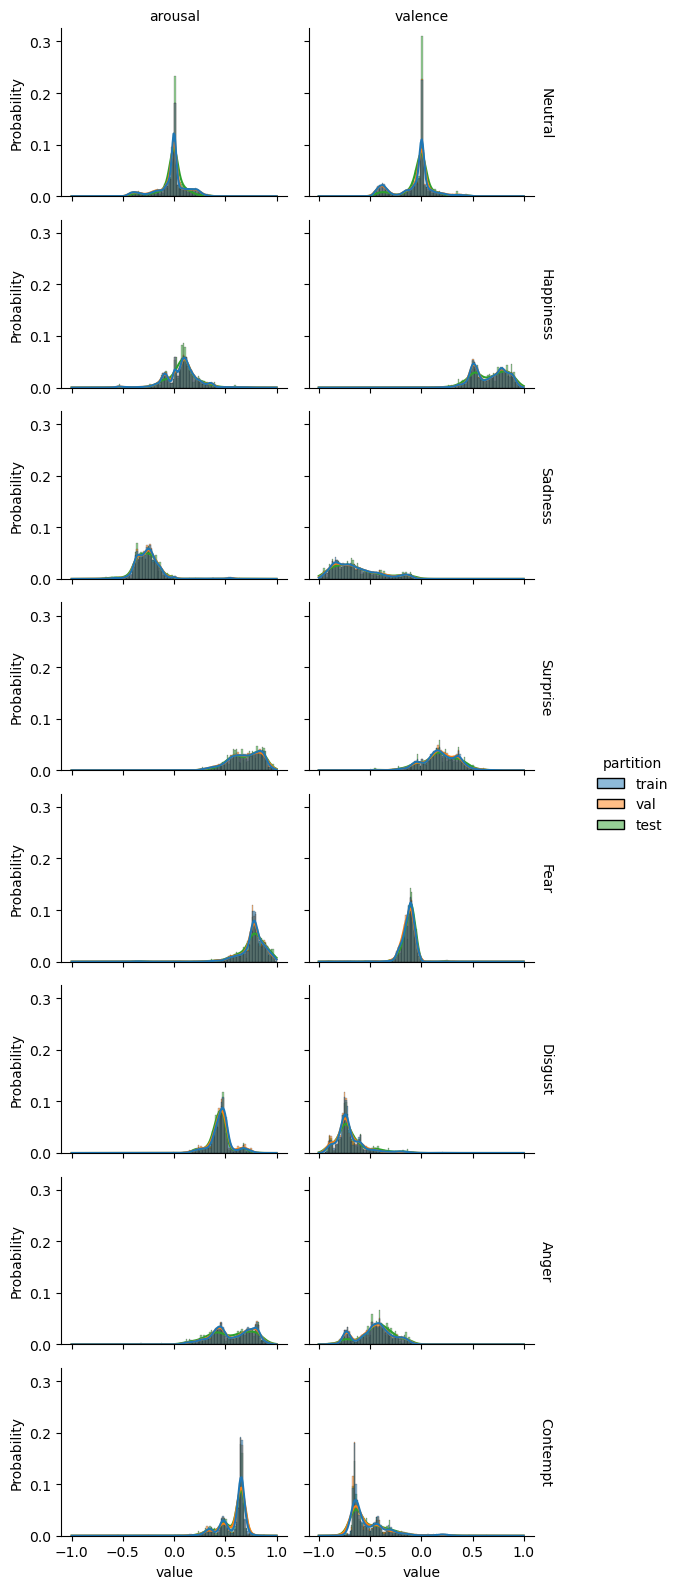

In [57]:
df_histplot_melt = df_img_all[['arousal', 'valence', 'partition', 'expression', 'img_id']].melt(id_vars=['partition', 'img_id', 'expression'])
label_map = {i: name for i, name in enumerate(dm.expression_labels)}
df_histplot_melt['expression'] = df_histplot_melt['expression'].map(label_map)
g = sns.displot(
    df_histplot_melt, x="value", row='expression', col="variable", hue="partition",
    kind='hist', stat='probability', common_norm=False, kde=True,
    aspect=1.5, height=2, row_order=dm.expression_labels, 
    facet_kws = {'margin_titles': True}
)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}');

In [84]:
img_files = df_img_all[(df_img_all.partition == 'train') & (df_img_all.expression == 5)]['filepath'].sample(5)

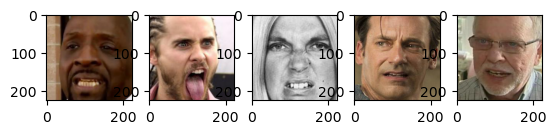

In [85]:
plt.figure()
for i, f in enumerate(img_files, start=1):
    with open(Path('..') / f, "rb") as f:
        img = Image.open(f)
        img = img.convert("RGB")
    plt.subplot(1, 5, i)
    plt.imshow(img)